# 🤗 Training conditional Latent DDPM (image-to-image) with Diffusers

This script adapts from the Hugging Face's [Diffusers](https://github.com/huggingface/diffusers) library to train a conditional image-to-image diffusion model.

[OPTION] Latent difusion

[OPTION] TODO: Image embedding guided

[OPTION] TODO: Text embedding guided

This example shows how to train a conditioned DDPM model using a paired dataset. This example suffices for most of the medical image reconstruction problem.

[OPTION] Lossless medical image dataloader

[OPTION] Lossless medical image evaluator and saver

[OPTION] TODO: Forward and backward operator in pytorch

### Installing the dependencies

[Custimized] This notebook leverages the customized dataset and its dataloader (.mat, .raw) 

[OPTION] [🤗 Datasets](https://huggingface.co/docs/datasets/index) library to load

[CUDA] The [🤗 Accelerate](https://huggingface.co/docs/accelerate/index) library to simplify training on any number of GPUs, with features like automatic gradient accumulation and tensorboard logging. Let's install them here:

In [1]:
#!pip install --upgrade diffusers[torch]
#!pip install datasets
#!pip install transformers

### Tested enviroment
nvcc: NVIDIA (R) Cuda compiler driver

Copyright (c) 2005-2022 NVIDIA Corporation

Cuda compilation tools, release 11.6, V11.6.124

Build cuda_11.6.r11.6/compiler.31057947_0

Python version 3.9.16

Torch version 1.13.1

In [2]:
# running environment
!nvcc --version
!python --version
import torch
print(torch.__version__)
torch.cuda.set_device(0)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
Python 3.9.16
1.13.1


### Open source

[Optional] To be able to share your model with the community, there are a few more steps to follow.|

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your **write** token:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Config

For convenience, we define a configuration grouping all the training hyperparameters. This would be similar to the arguments used for a [training script](https://github.com/huggingface/diffusers/tree/main/examples).
Here we choose reasonable defaults for hyperparameters like `num_epochs`, `learning_rate`, `lr_warmup_steps`, but feel free to adjust them if you train on your own dataset. For example, `num_epochs` can be increased to 100 for better visual quality.

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    
    latent_diffusion = False
    
    output_dir = 'train/L30-ddpm1'  # the model namy locally and on the HF Hub
    pretrain_dir = None # the pretrained model namy locally and on the HF Hub
    
    image_size = 512 # the generated image resolution
    image_channel = 1 # must use to_rgb during training and inference if vae is preloaded
    train_batch_size = 2
    eval_batch_size = 2  # how many images to sample during evaluation
    num_epochs = 100
    num_train_timesteps = 1000
    num_inference_timesteps = 250
    data_augmentation = False
    
    # learning rate
    lr_scheduler_type = "cosine"
    # choose from "linear", "cosine", "cosine_with_restarts", "polynomial","constant", "constant_with_warmup"]'
    learning_rate = 1e-4
    lr_warmup_steps = 25000
    
    # optimization
    mixed_precision = 'no'  # `no` for float32, `fp16` for automatic mixed precision, `bp16`
    gradient_accumulation_steps = 1
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    
    # model save
    save_image_epochs = 5
    save_model_epochs = 5
    pretrained_model_name_or_path = 'stabilityai/stable-diffusion-x4-upscaler' #'CompVis/stable-diffusion-v1-5'
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## Loading the dataset

[OPTION 1] Load local folders with a loading script.

[OPTION 2] Use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our image dataset.

In [5]:
import datasets
from datasets import load_dataset

# existing hub dataset
# config.dataset = "huggan/smithsonian_butterflies_subset"
# config.dataset = "huggan/selfie2anime"
# config.dataset = "huggan/night2day"
# config.dataset = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset, split="train")
 
# Or just load images from a local folder with a loading script
# train_cases = (0, 5177)
# val_cases = (5177, 5482)
# test_cases = (5482, 5829)

train_cases = (0, 10000)
val_cases = (10001, 11000)
test_cases = (11001, 12000)

dataset = load_dataset(
    path = '/mnt/ssd_256/mayo_LVA',
    name = 'AAPM Limited View Dataset',
    data_dir = '/mnt/ssd_256/mayo_LVA',
    cache_dir = "./data",
    img_height = config.image_size,
    img_width = config.image_size,
    splits = {datasets.Split.TRAIN: train_cases, datasets.Split.VALIDATION: val_cases , datasets.Split.TEST: test_cases}
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset mayo_lva downloaded and prepared to /mnt/hdd_2T/Diffusion-Chengzhu/data/mayo_lva/AAPM Limited View Dataset-892baf0aface369e/2.0.0/f79ee6fb6f030435e91662df13e5a41c164291f0926eb4d71a507fdf1688bbe8. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset contains the splitted labels and several extra `features` (columns), but the one that we're interested in is `image`. Note that these images are stacked as a list if we load them from .raw or .mat. We must convert it to numpy(lossless), pil(lossy if rgb) or tensor.

In [6]:
dataset
print('Data type:', type(dataset["train"][0]["imageA"]))

Data type: <class 'list'>


Since the [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) feature loads the images with PIL, we can easily look at a few examples:

/tmp/ipykernel_530486/2392659302.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_530486/2392659302.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


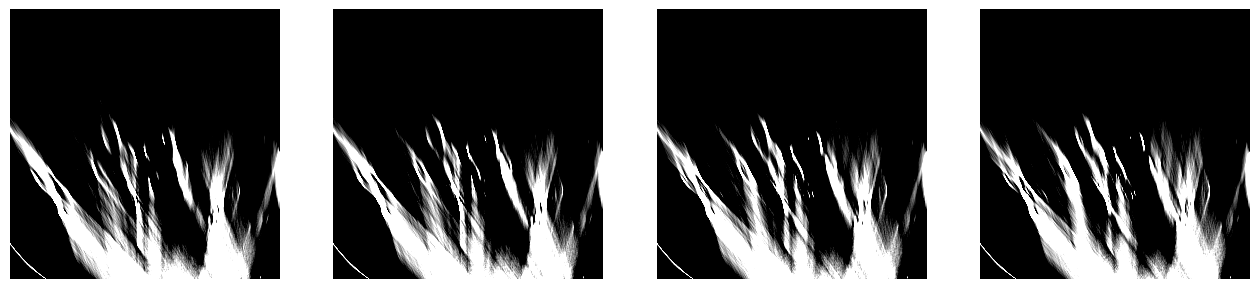

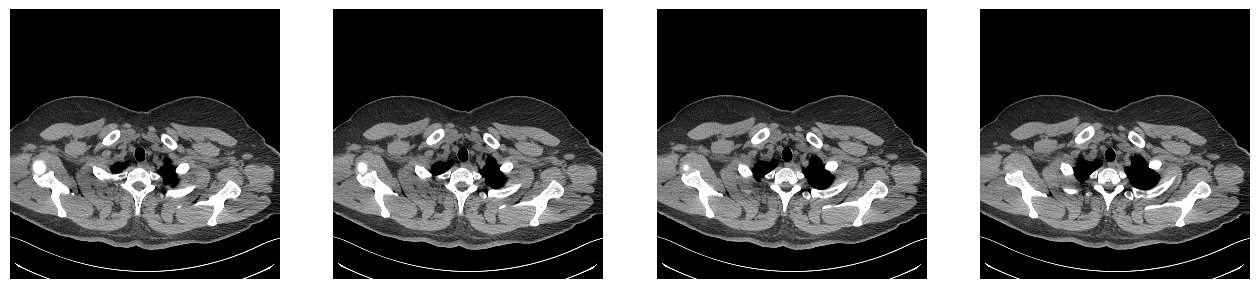

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

l, r = 25, 400
win_min, win_max = (l-r/2+1024)/4095, (l+r/2+1024)/4095

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][20:24]["imageA"]):
    image = np.array(image, dtype=np.float32)
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][20:24]["imageB"]):
    image = np.array(image, dtype=np.float32)
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()


## Prepare data for augmentation
The images in the dataset are all different, so we need to preprocess them first:
* `Resize` makes the images conform to a square resolution of `config.image_size`
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `RandomVerticalFlip` augments the dataset by randomly flip the images.
* `Normalize` is important to rescale the pixel values into a `[-1, 1]` range (which our model will expect).

Trick: for gray scale images, make sure to perform data augmentation first, and then sent it to rgb if needed.

In [8]:
from torchvision import transforms

norm_mean, norm_scale = 0.0, 1.0
# todo config paired data_augmentation
# seed = np.random.randint(2147483647)
# random.seed(seed)
# torch.manual_seed(seed)
preprocess = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((config.image_size, config.image_size)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.5], [0.5]),
        transforms.Normalize([norm_mean], [norm_scale]),
    ]
)

🤗 Datasets offer a handy `set_transform()` method to apply the image transformations on the fly during training:

In [9]:
import random

def to_rgb(grayscale_image): # tenosr
    return grayscale_image.repeat(1, 3, 1, 1) if grayscale_image.shape[1] == 1 else grayscale_image

def to_gray(rgb_im): # image
    return 0.2989*rgb_im[...,0] + 0.5870*rgb_im[...,1] + 0.1140*rgb_im[...,2] if rgb_im.shape[-1] == 3 else rgb_im.squeeze(axis=-1)
  
def transform(examples):
    imagesA = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageA"]]
    imagesB = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageB"]]
    return {"imageA": imagesA, "imageB": imagesB}

dataset.set_transform(transform)

Let's view the transformed image tensor through piepline.

/tmp/ipykernel_530486/3927043381.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_530486/3927043381.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


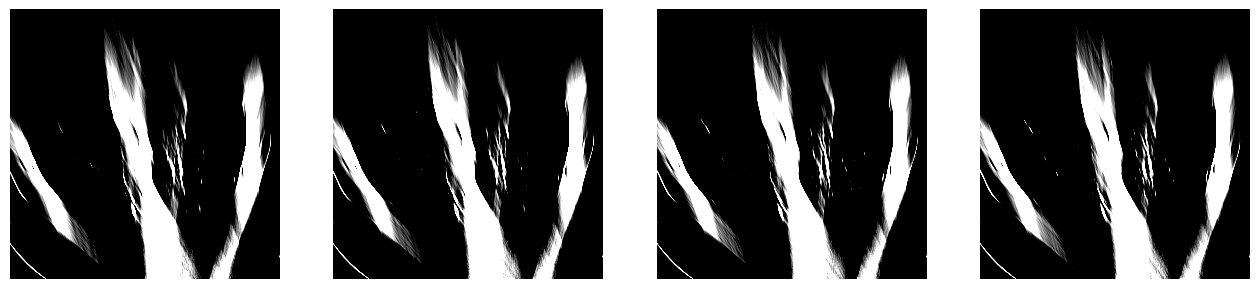

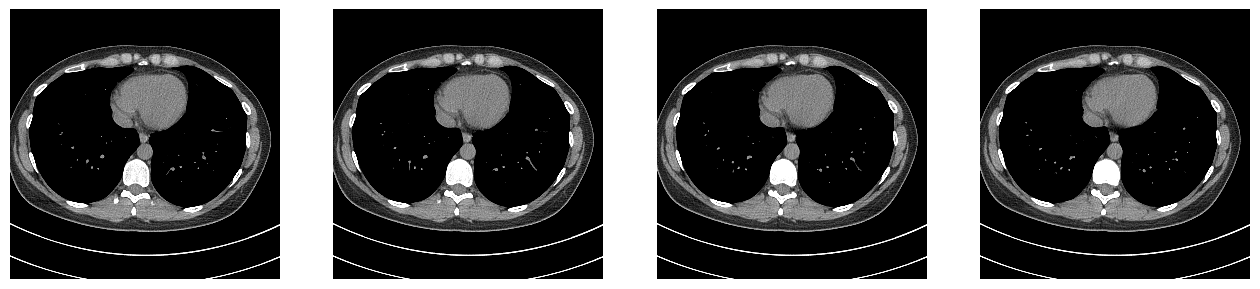

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["validation"][:4]["imageA"]):
    image = image.permute(1, 2, 0)
    axs[i].imshow(image* norm_scale + norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["validation"][:4]["imageB"]):
    image = image.permute(1, 2, 0)
    axs[i].imshow(image* norm_scale + norm_mean, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.

In [11]:
train_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=config.train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset['validation'], batch_size=config.eval_batch_size, shuffle=True)

## Defining the diffusion model

Here we set up our diffusion model. Diffusion models are neural networks that are trained to predict slightly less noisy images from a noisy input. At inference, they can be used to iteratively transform a random noise to generate an image:

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

Don't worry too much about the math if you're not familiar with it, the import part to remember is that our model corresponds to the arrow $p_{\theta}(x_{t-1}|x_{t})$ (which is a fancy way of saying: predict a slightly less noisy image).

The interesting part is that it's really easy to add some noise to an image, so the training can happen in a semi-supervised fashion as follows:
1. Take an image from the training set.
2. Apply to it some random noise $t$ times (this will give the $x_{t-1}$ and the $x_{t}$ in the figure above).
3. Give this noisy image to the model along with the value of $t$.
4. Compute a loss from the output of the model and the noised image $x_{t-1}$.

Then we can apply gradient descent and repeat this process multiple times.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

In a nutshell:
- the model has the input image go through several blocks of ResNet layers which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch. The models in our case is preset and saved in model.py. Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram).


In [12]:
from diffusers import UNet2DModel, AutoencoderKL
#from models import UNet2DModel_Superres

if config.latent_diffusion:
    in_channels = 4
else:
    # TODO: if load from hub, chances are input channel requires 3, therefore torgb needed
    in_channels = config.image_channel

if config.pretrain_dir is None:  
    model = UNet2DModel(
        sample_size=config.image_size,  # the target image resolution
        in_channels=in_channels*2,  # the number of input channels, 3 for RGB images, 3 for latents
        out_channels=in_channels,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
        down_block_types=( 
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D", 
            "DownBlock2D", 
            "DownBlock2D", 
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D", 
            "UpBlock2D"  
          ),
    )   
#     model = UNet2DModel_Superres(        
#         sample_size=config.image_size,  # the target image resolution
#         in_channels=in_channels*2,  # the number of input channels, 3 for RGB images, 3 for latents
#         out_channels=in_channels,  # the number of output channels
#     )
else:
    model = UNet2DModel.from_pretrained(config.pretrain_dir, subfolder="unet")

if config.latent_diffusion:
    vae = AutoencoderKL.from_pretrained(config.pretrained_model_name_or_path, subfolder="vae")
    vae.requires_grad_(False)

Note that our model takes in the (noisy) image and also the current time-step (as we saw before in the training overview). That time-step information is converted for the model using a sinusoidal positional embedding, similar to what Transformer models often do.

Now that we have our model, we just need an object to *add noise to an image*. This is done by the **schedulers** in the `diffusers` library.

## Defining the noise scheduler

Depending on the diffusion algorithm you want to use, the way images are noised is slightly different. That's why 🤗 Diffusers contains different scheduler classes which each define the algorithm-specific diffusion steps. Here we are going to use the `DDPMScheduler` which corresponds to the training denoising and training algorithm proposed in [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239).

And let's check the output is a tensor of the same exact shape:

In [13]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)

# optional:
# DDIMScheduler,
# PNDMScheduler,
# LMSDiscreteScheduler,
# EulerDiscreteScheduler,
# EulerAncestralDiscreteScheduler,
# DPMSolverMultistepScheduler,

This noise scheduler takes a batch of images from the trainng set, a batch of random noise of the same shape and the timesteps for each image (which correspond to the number of times we want to apply noise to each image).

In the DDPM algorithm, the training objective of the model is then to be able to predict the noise we used in `noise_scheduler.add_noise`.

## Setting up training

We have all we need to be able to train our model! Let's use a standard AdamW optimizer:

In [14]:
#@title set optimizer
import torch.nn.functional as F

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(config.adam_beta1, config.adam_beta2),)

In [15]:
#@title Add a [OPTIONAL: cosine learning rate] schedule:
from diffusers.optimization import get_scheduler, get_cosine_schedule_with_warmup
        
lr_scheduler = get_scheduler(
    config.lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps * config.gradient_accumulation_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

To evaluate our model, we use the `DDPMPipeline` which is an easy way to perform end-to-end inference (see this notebook [TODO link] for more detail). We will use this pipeline to generate a batch of sample images and save it as a grid to the disk. 

In [16]:
#@title Setting up validation
import math
import os
from scipy.io import loadmat, savemat

# todo: RGB problems.
def make_grid_pil(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image.convert('L'), box=(i%cols*w, i//cols*h))
    return grid

def tensor_to_pil(images):
        """
        Convert a tensor image [-1 1] or a batch of images to a PIL image.
        """
        # a tensor is already in [-1 1]
        images = images.permute(0,2,3,1).numpy() * norm_scale + norm_mean
        images = (images.clip(0, 1) * 255).round().astype("uint8")
        
        if images.ndim == 3:
            images = images[None, ...]
        if images.shape[-1] == 1:
            # special case for grayscale (single channel) images
            pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
        else:
            pil_images = [Image.fromarray(image) for image in images]

        return pil_images
    
def evaluate_pil(config, cimages, pipeline, seed, epoch=0, out_dir="samples"):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        image = cimages,
        num_inference_steps = config.num_inference_timesteps,
        generator = torch.manual_seed(seed),
        output_type = 'tensor'
    ).images

    # Make a grid out of the images
    side_len = int(math.sqrt(len(images)))
    cimages, images = tensor_to_pil(cimages), tensor_to_pil(images)
    image_cond = make_grid_pil(cimages, rows=side_len, cols=side_len)
    image_grid = make_grid_pil(images, rows=side_len, cols=side_len)

    # Save the images
    test_dir = os.path.join(config.output_dir, out_dir)
    os.makedirs(test_dir, exist_ok=True)
    image_cond.save(f"{test_dir}/{epoch:04d}_input.png")
    image_grid.save(f"{test_dir}/{epoch:04d}_output.png")

def evaluate_tensor(config, cimages, pipeline, seed, epoch=0, out_dir=None):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        image = cimages,
        guidance_scale = 1,
        num_inference_steps = config.num_inference_timesteps,
        generator = torch.manual_seed(seed),
        output_type = 'tensor'
    ).images
    
    if out_dir:
        # Make a grid out of the images
        side_len = int(math.sqrt(len(images)))
        image_cond = make_grid_pil(tensor_to_pil(cimages), rows=side_len, cols=side_len)
        image_grid = make_grid_pil(tensor_to_pil(images), rows=side_len, cols=side_len)

        # Save the images
        test_dir = os.path.join(config.output_dir, out_dir)
        os.makedirs(test_dir, exist_ok=True)
        image_cond.save(f"{test_dir}/{epoch:04d}_input.png")
        image_grid.save(f"{test_dir}/{epoch:04d}_output.png")

    return cimages*norm_scale+norm_mean, images*norm_scale+norm_mean

## Image-to-image Training Script

With this in end, we can group all together and write our training function. This just wraps the training step we saw in the previous section in a loop, using Accelerate for easy TensorBoard logging, gradient accumulation, mixed precision training and multi-GPUs or TPU training.

In [17]:
#@title Prepare pipline
from pipeline import cLDMPipeline, cDDPMPipeline
from accelerate import Accelerator
from accelerate.logging import get_logger
from tqdm.auto import tqdm
from torchvision.utils import make_grid

logger = get_logger(__name__, log_level="INFO")

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):

    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    
    logger = get_logger(__name__, log_level="INFO")
    logger.info(accelerator.state, main_process_only=False)
    
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16    
    
    # Move text_encode and vae to gpu and cast to weight_dtype
    # text_encoder.to(accelerator.device, dtype=weight_dtype)
    if config.latent_diffusion:       
        vae.to(accelerator.device, dtype=weight_dtype)
    
    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("train_log") 
   
    global_step = 0
    
    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        train_loss = 0.0
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch['imageB'].clamp(-1, 1).to(weight_dtype)
            if config.latent_diffusion:
                clean_images = vae.encode(to_rgb(clean_images)).latent_dist.sample()
                clean_images = clean_images * vae.config.scaling_factor
            
            condition_images = batch['imageA'].clamp(-1, 1).to(weight_dtype)
            if config.latent_diffusion:
                condition_images = vae.encode(to_rgb(condition_images)).latent_dist.sample()
                condition_images = condition_images * vae.config.scaling_factor

            # Sample noise to add to the images
            noise = torch.randn_like(clean_images)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device)
            timesteps = timesteps.long()
            
            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            
            noisy_clean_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            # TODO: Get the text embedding for conditioning
            # TODO: Get the image embedding for conditioning
            
            noisy_images= torch.cat([noisy_clean_images, condition_images], dim=1)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps).sample
                loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean") # target = noise
                
                avg_loss = accelerator.gather(loss.repeat(config.train_batch_size)).mean()
                train_loss += avg_loss.item() / config.gradient_accumulation_steps

                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": train_loss/(step+1), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        # log tensorboard
        logs = {"loss": train_loss/(step+1)}
        accelerator.log(logs, step=epoch) 

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        # TO DO: Validation dataset (may be too slow, think about it)
        if accelerator.is_main_process:
            if val_dataloader is not None and (epoch + 1) % config.save_image_epochs == 0:
                logger.info(
                    f"Running validation..."
                )
                val_batch = next(iter(val_dataloader))      
                if config.latent_diffusion:
                    cimages = to_rgb(val_batch['imageA']).clamp(-1, 1).to(weight_dtype)
                    pipeline = cLDMPipeline(vae=vae, unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                else:
                    cimages = val_batch['imageA'].clamp(-1, 1).to(weight_dtype)
                    pipeline = cDDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

                pipeline = pipeline.to(accelerator.device)
                # Evaluate and visualize by pil lose precision, not suitable for medical imaging.
                with torch.autocast(
                    str(accelerator.device), enabled=accelerator.mixed_precision == "fp16"
                ):
                    # val_images = evaluate_pil(config, cimages, pipeline, config.seed, epoch)
                    cimages, vimages = evaluate_tensor(config, cimages, pipeline, config.seed, epoch, "samples")

                for tracker in accelerator.trackers:
                    if tracker.name == "tensorboard":
                        #np_images = np.stack([np.asarray(img) for img in val_images])
                        tracker.writer.add_images(
                            "validation", make_grid(vimages), epoch+1, dataformats="CHW"
                        )
                        tracker.writer.add_images(
                            "input", make_grid(cimages), epoch+1, dataformats="CHW"
                        )                        

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.latent_diffusion:
                    pipeline = cLDMPipeline(vae=vae, unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                else:
                    pipeline = cDDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                pipeline.save_pretrained(config.output_dir)
            
            
    accelerator.end_training()

In [18]:
%load_ext tensorboard
%tensorboard --logdir ./{config.output_dir}/logs/train_log --port 6008

## Let's train!

Let's launch the training (including multi-GPU training) from the notebook using Accelerate's `notebook_launcher` function:

In [19]:
torch.cuda.empty_cache()

In [ ]:
from accelerate import notebook_launcher, debug_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

# Inference (one batch)
The final step is to perform inference using the corresponding pipeline and the trained network. Let's have a look at the final image grid produced by the trained diffusion model:

In [ ]:
import torch
torch.cuda.set_device(0)

Inference configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class InferenceConfig:
    
    latent_diffusion = True
    
    output_dir = 'train/L30-ddpm1'  # the model namy locally and on the HF Hub
    pretrain_dir = 'train/L30-ddpm1' # the pretrained model namy locally and on the HF Hub
    image_size = 512 # the generated image resolution
    eval_batch_size = 16  # how many images to sample during evaluation
    num_inference_timesteps = 1000
    
config = InferenceConfig()

reload dataset

In [ ]:
import datasets
from datasets import load_dataset

dataset = load_dataset(
    path = '/mnt/ssd_256/mayo_LVA',
    name = 'AAPM Low Dose Dataset',
    data_dir = '/mnt/ssd_256/mayo_LVA',
    cache_dir = "./data",
    img_height = config.image_size,
    img_width = config.image_size,
    #splits = {datasets.Split.TRAIN: train_cases, datasets.Split.VALIDATION: val_cases , datasets.Split.TEST: test_cases}
)

utils

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

norm_mean, norm_scale = 0.0, 1.0

def to_rgb(grayscale_image): # tenosr
    return grayscale_image.repeat(1, 3, 1, 1) if grayscale_image.shape[1] == 1 else grayscale_image

def to_gray(rgb_im): # image
    return 0.2989*rgb_im[...,0] + 0.5870*rgb_im[...,1] + 0.1140*rgb_im[...,2] if rgb_im.shape[-1] == 3 else rgb_im.squeeze(axis=-1)

preprocess = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((config.image_size, config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize([norm_mean], [norm_scale]),
    ]
)

def transform(examples):
    imagesA = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageA"]]
    imagesB = [preprocess(np.array(image, dtype=np.float32)) for image in examples["imageB"]]
    return {"imageA": imagesA, "imageB": imagesB}

dataset.set_transform(transform)
val_dataloader = torch.utils.data.DataLoader(dataset['train'], batch_size=config.eval_batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset['test'], batch_size=config.eval_batch_size, shuffle=True)

In [ ]:
#@title Setting up validation
import math
import os
from scipy.io import loadmat, savemat

def evaluate_image(config, cimages, pipeline, seed, batch=0, out_dir='test'):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        image = cimages,
        num_inference_steps = config.num_inference_timesteps,
        generator = torch.manual_seed(seed),
        output_type = 'numpy',
    ).images
    
    images = to_gray(images).transpose((1,2,0))
    
    cimages = cimages[:,0,:,:].permute(1,2,0).cpu().numpy()
    
    # Save the matlab/raw files for visualization
    test_dir = os.path.join(config.output_dir, out_dir)
    os.makedirs(test_dir, exist_ok=True)
    savemat(f"{test_dir}/{batch:04d}.mat", {"input": cimages*norm_scale+norm_mean, "output": images*norm_scale+norm_mean})
    
    return images

load pipline

In [ ]:
from pipeline import cLDMPipeline, cDDPMPipeline
from diffusers import DDPMScheduler
import os

trained_model_dir = config.pretrain_dir

inference_seed = 20
test_batch = next(iter(val_dataloader))

if config.latent_diffusion:
    cimages = to_rgb(test_batch['imageA'].clamp(-1, 1))
    pipeline = cLDMPipeline.from_pretrained(trained_model_dir)
else:
    cimages = test_batch['imageA'].clamp(-1, 1)                
    pipeline = cDDPMPipeline.from_pretrained(trained_model_dir)
    
pipeline.scheduler

Start inference ...

In [ ]:
pipeline = pipeline.to("cuda")    
evaluate_image(config, cimages, pipeline, inference_seed, batch=0, out_dir="test")

# input and label
in_ = test_batch['imageA'][:,0,:,:].clamp(-1,1).permute(1,2,0).cpu().numpy()
truth = test_batch['imageB'][:,0,:,:].clamp(-1,1).permute(1,2,0).cpu().numpy()

# Save the matlab/raw files for visualization
test_dir = os.path.join(config.output_dir, "test")
savemat(f"{test_dir}/0000_label.mat", {"input": in_*norm_scale+norm_mean, "truth": truth*norm_scale+norm_mean})
    
del pipeline
torch.cuda.empty_cache()

Visualize from saved .mat files

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

test_dir = os.path.join(config.output_dir, "test")
images = loadmat(f"{test_dir}/0000.mat")
input_image = images['input'].transpose((2,0,1))
output_image = images['output'].transpose((2,0,1))
images = loadmat(f"{test_dir}/0000_label.mat")
truth_image = images['truth'].transpose((2,0,1))

l, r = 25, 400
win_min, win_max = (l-r/2+1024)/4095, (l+r/2+1024)/4095

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(input_image[:config.eval_batch_size]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(output_image[:config.eval_batch_size]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(truth_image[:config.eval_batch_size]):
    axs[i].imshow(image, cmap='gray', vmin=win_min, vmax=win_max)
    axs[i].set_axis_off()
fig.show()

# Inference (test dataset)

In [ ]:
#%%script false --no-raise-error
inference_seed = 5

if config.latent_diffusion:
    pipeline = cLDMPipeline.from_pretrained(config.pretrain_dir)
else:              
    pipeline = cDDPMPipeline.from_pretrained(config.pretrain_dir)
    
pipeline = pipeline.to("cuda")
for step, test_batch in enumerate(test_dataloader):
    if config.latent_diffusion:
        cimages = to_rgb(test_batch['imageA'])
    else:
        cimages = test_batch['imageA']                    
    evaluate_image(config, cimages, pipeline, inference_seed,  batch=step+1, out_dir="test")
    # input and label
    in_ = test_batch['imageA'][:,0,:,:].permute(1,2,0).cpu().numpy()
    truth = test_batch['imageB'][:,0,:,:].permute(1,2,0).cpu().numpy()

    # Save the matlab/raw files for visualization
    test_dir = os.path.join(config.output_dir, "test")
    savemat(f"{test_dir}/{(step+1):04d}_label.mat", {"input": in_*norm_scale+norm_mean, "truth": truth*norm_scale+norm_mean})
    
del pipeline
torch.cuda.empty_cache()